# Forecasting Unit Sales (Task 1) 

In [80]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

color_pal = sns.color_palette()
%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Step 1: Data Loading and Initial Inspection(Training Data)

In [3]:
train_df.head()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,units,unit_price
0,2022-04-12_B09KDTS4DC,2022-04-12,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0,0.0
1,2022-04-12_B09MR2MLZH,2022-04-12,B09MR2MLZH,NapQueen 12 Inch Bamboo Charcoal Queen Size Me...,NaN,NAPQUEEN,0.0,0.0
2,2022-04-12_B09KSYL73R,2022-04-12,B09KSYL73R,"NapQueen Elsa 8"" Innerspring Mattress, Twin XL",NaN,NAPQUEEN,0.0,0.0
3,2022-04-12_B09KT5HMNY,2022-04-12,B09KT5HMNY,"NapQueen Elsa 6"" Innerspring Mattress, Twin",NaN,NAPQUEEN,0.0,0.0
4,2022-04-12_B09KTF8ZDQ,2022-04-12,B09KTF8ZDQ,"NapQueen Elsa 6"" Innerspring Mattress, Twin XL",NaN,NAPQUEEN,0.0,0.0


In [4]:
train_df.tail()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,units,unit_price
101485,2024-05-31_B0CR4BGLK5,2024-05-31,B0CR4BGLK5,NaN,604.73,NAPQUEEN,NaN,0.00
101486,2024-05-31_B0CR4BG4ZW,2024-05-31,B0CR4BG4ZW,NaN,261.21,NAPQUEEN,2.0,225.32
101487,2024-05-31_B0CR49NR3B,2024-05-31,B0CR49NR3B,NaN,0.00,NAPQUEEN,NaN,0.00
101488,2024-05-31_B0CR49N6MQ,2024-05-31,B0CR49N6MQ,NaN,0.00,NAPQUEEN,NaN,0.00
101489,2024-05-31_B0CR4BK4FW,2024-05-31,B0CR4BK4FW,NaN,0.00,NAPQUEEN,NaN,0.00


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101490 entries, 0 to 101489
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          101490 non-null  object 
 1   date        101490 non-null  object 
 2   Item Id     101488 non-null  object 
 3   Item Name   99658 non-null   object 
 4   ad_spend    77303 non-null   float64
 5   anarix_id   101490 non-null  object 
 6   units       83592 non-null   float64
 7   unit_price  101490 non-null  float64
dtypes: float64(3), object(5)
memory usage: 6.2+ MB


In [6]:
train_df.describe()

,ad_spend,units,unit_price
count,77303.000000,83592.000000,101490.000000
mean,110.771470,10.284381,106.750922
std,529.303777,68.945915,425.704733
min,0.000000,-173.000000,-8232.000000
25%,0.000000,0.000000,0.000000
50%,4.230000,1.000000,0.000000
75%,44.310000,5.000000,0.000000
max,47934.990000,9004.000000,21557.390000


In [7]:
train_df.isnull().sum()

ID                0
date              0
Item Id           2
Item Name      1832
ad_spend      24187
anarix_id         0
units         17898
unit_price        0
dtype: int64

In [8]:
print("Unique values in 'ID':", train_df['ID'].nunique())
print("Unique values in 'Item Id':", train_df['Item Id'].nunique())
print("Unique values in 'Item Name':", train_df['Item Name'].nunique())

Unique values in 'ID': 101490
Unique values in 'Item Id': 217
Unique values in 'Item Name': 199


# Step 2: Data Loading and Initial Inspection(Testing Data)

In [9]:
test_df.head()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,unit_price
0,2024-07-01_B09KDR64LT,2024-07-01,B09KDR64LT,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
1,2024-07-01_B09KDTS4DC,2024-07-01,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0
2,2024-07-01_B09KDTHJ6V,2024-07-01,B09KDTHJ6V,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
3,2024-07-01_B09KDQ2BWY,2024-07-01,B09KDQ2BWY,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
4,2024-07-01_B09KDYY3SB,2024-07-01,B09KDYY3SB,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",101.72,NAPQUEEN,1094.5


In [10]:
test_df.tail()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,unit_price
2828,2024-07-28_B0BRCW2B64,2024-07-28,B0BRCW2B64,"NapQueen Anula Green Tea 12'', Queen",11.78,NAPQUEEN,0.0
2829,2024-07-28_B0CFV6V981,2024-07-28,B0CFV6V981,NaN,1.17,NAPQUEEN,0.0
2830,2024-07-28_B0BNL5BKMK,2024-07-28,B0BNL5BKMK,"NapQueen 2'' Bamboo Charcoal Mattress Topper, ...",0.00,NAPQUEEN,0.0
2831,2024-07-28_B0CR49BQRS,2024-07-28,B0CR49BQRS,NaN,1.87,NAPQUEEN,0.0
2832,2024-07-28_B0CY5QQ49F,2024-07-28,B0CY5QQ49F,NaN,1.45,NAPQUEEN,0.0


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          2833 non-null   object 
 1   date        2833 non-null   object 
 2   Item Id     2833 non-null   object 
 3   Item Name   2489 non-null   object 
 4   ad_spend    1382 non-null   float64
 5   anarix_id   2833 non-null   object 
 6   unit_price  2833 non-null   float64
dtypes: float64(2), object(5)
memory usage: 155.1+ KB


In [12]:
test_df.describe()

,ad_spend,unit_price
count,1382.000000,2833.000000
mean,198.838032,98.725873
std,797.354508,383.585307
min,0.000000,-1988.180000
25%,0.730000,0.000000
50%,39.200000,0.000000
75%,156.012500,0.000000
max,18724.850000,6870.000000


In [13]:
test_df.isnull().sum()

ID               0
date             0
Item Id          0
Item Name      344
ad_spend      1451
anarix_id        0
unit_price       0
dtype: int64

In [14]:
print("\nUnique values in 'Item Id':", test_df['Item Id'].nunique())
print("Unique values in 'Item Name':", test_df['Item Name'].nunique())


Unique values in 'Item Id': 155
Unique values in 'Item Name': 142


# STEP 3: DATA PRE PROCESSING

In [15]:
#CLEAN TRAIN DATA 

train_df['date'] = pd.to_datetime(train_df['date'])

train_df = train_df.sort_values(['Item Id', 'date'])

In [16]:
train_df = train_df.dropna(subset=['Item Id'])

In [17]:
train_df['ad_spend'] = train_df['ad_spend'].fillna(0)
train_df['units'] = train_df['units'].fillna(0)

In [18]:
train_df['Item Name'] = train_df['Item Name'].fillna('Unknown')

In [19]:
train_df['units'] = train_df['units'].clip(lower=0) 
train_df['unit_price'] = train_df['unit_price'].clip(lower=0) 

train_df['missing_name'] = train_df['Item Name'].apply(lambda x: 1 if x == 'Unknown' else 0)

In [20]:
print("Rows in dataset after cleaning:", len(train_df))
print("\nMissing values after cleaning:")
print(train_df.isnull().sum())
print("\nDataset info after cleaning:")
train_df.info()

Rows in dataset after cleaning: 101488

Missing values after cleaning:
ID              0
date            0
Item Id         0
Item Name       0
ad_spend        0
anarix_id       0
units           0
unit_price      0
missing_name    0
dtype: int64

Dataset info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 101488 entries, 62967 to 101466
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ID            101488 non-null  object        
 1   date          101488 non-null  datetime64[ns]
 2   Item Id       101488 non-null  object        
 3   Item Name     101488 non-null  object        
 4   ad_spend      101488 non-null  float64       
 5   anarix_id     101488 non-null  object        
 6   units         101488 non-null  float64       
 7   unit_price    101488 non-null  float64       
 8   missing_name  101488 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1), objec

In [21]:
print("\nBasic statistics after cleaning:")
print(train_df.describe())


Basic statistics after cleaning:
                                date       ad_spend          units  \
count                         101488  101488.000000  101488.000000   
mean   2023-07-09 19:09:44.297651200      84.374182       8.511105   
min              2022-04-12 00:00:00       0.000000       0.000000   
25%              2023-02-26 00:00:00       0.000000       0.000000   
50%              2023-07-16 00:00:00       0.720000       0.000000   
75%              2023-12-13 00:00:00      21.642500       3.000000   
max              2024-05-31 00:00:00   47934.990000    9004.000000   
std                              NaN     464.354660      62.680788   

          unit_price   missing_name  
count  101488.000000  101488.000000  
mean      107.256203       0.018032  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max     21557.390000       1.000000  
std       424.513596       0.13

In [22]:
# CLEANING TEST DATA 

In [23]:
test_df.head()

,ID,date,Item Id,Item Name,ad_spend,anarix_id,unit_price
0,2024-07-01_B09KDR64LT,2024-07-01,B09KDR64LT,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
1,2024-07-01_B09KDTS4DC,2024-07-01,B09KDTS4DC,"NapQueen Elizabeth 8"" Gel Memory Foam Mattress...",NaN,NAPQUEEN,0.0
2,2024-07-01_B09KDTHJ6V,2024-07-01,B09KDTHJ6V,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
3,2024-07-01_B09KDQ2BWY,2024-07-01,B09KDQ2BWY,"NapQueen Elizabeth 12"" Gel Memory Foam Mattres...",NaN,NAPQUEEN,0.0
4,2024-07-01_B09KDYY3SB,2024-07-01,B09KDYY3SB,"NapQueen Elizabeth 10"" Gel Memory Foam Mattres...",101.72,NAPQUEEN,1094.5


In [24]:
test_df['date'] = pd.to_datetime(test_df['date'])

In [25]:
test_df['ad_spend'] = test_df['ad_spend'].fillna(0)

In [26]:
test_df['Item Name'] = test_df['Item Name'].fillna('Unknown')

In [27]:
test_df['unit_price'] = test_df['unit_price'].clip(lower=0) 

test_df['missing_name'] = test_df['Item Name'].apply(lambda x: 1 if x == 'Unknown' else 0)

In [28]:
print("Rows in dataset after cleaning:", len(test_df))
print("\nMissing values after cleaning:")
print(test_df.isnull().sum())
print("\nDataset info after cleaning:")
test_df.info()

Rows in dataset after cleaning: 2833

Missing values after cleaning:
ID              0
date            0
Item Id         0
Item Name       0
ad_spend        0
anarix_id       0
unit_price      0
missing_name    0
dtype: int64

Dataset info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID            2833 non-null   object        
 1   date          2833 non-null   datetime64[ns]
 2   Item Id       2833 non-null   object        
 3   Item Name     2833 non-null   object        
 4   ad_spend      2833 non-null   float64       
 5   anarix_id     2833 non-null   object        
 6   unit_price    2833 non-null   float64       
 7   missing_name  2833 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 177.2+ KB


In [29]:
print("\nBasic statistics after cleaning:")
print(test_df.describe())


Basic statistics after cleaning:
                                date      ad_spend   unit_price  missing_name
count                           2833   2833.000000  2833.000000   2833.000000
mean   2024-07-13 16:54:33.420402176     96.997586   100.667754      0.121426
min              2024-07-01 00:00:00      0.000000     0.000000      0.000000
25%              2024-07-07 00:00:00      0.000000     0.000000      0.000000
50%              2024-07-14 00:00:00      0.000000     0.000000      0.000000
75%              2024-07-20 00:00:00     36.030000     0.000000      0.000000
max              2024-07-28 00:00:00  18724.850000  6870.000000      1.000000
std                              NaN    565.607189   379.505541      0.326679


# STEP 4: EDA ( Exploratory Data Analysis)

In [30]:
# Basic info
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

print("\nTrain dataset columns:")
print(train_df.columns)
print("\nTest dataset columns:")
print(test_df.columns)

print("\nTrain dataset info:")
train_df.info()

print("\nTest dataset info:")
test_df.info()

Train dataset shape: (101488, 9)
Test dataset shape: (2833, 8)

Train dataset columns:
Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id', 'units',
       'unit_price', 'missing_name'],
      dtype='object')

Test dataset columns:
Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id',
       'unit_price', 'missing_name'],
      dtype='object')

Train dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 101488 entries, 62967 to 101466
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ID            101488 non-null  object        
 1   date          101488 non-null  datetime64[ns]
 2   Item Id       101488 non-null  object        
 3   Item Name     101488 non-null  object        
 4   ad_spend      101488 non-null  float64       
 5   anarix_id     101488 non-null  object        
 6   units         101488 non-null  float64       
 7   unit_price    101488 non-nu

In [31]:
print(train_df.describe())

# Check for missing values
print(train_df.isnull().sum())
print(test_df.isnull().sum())

                                date       ad_spend          units  \
count                         101488  101488.000000  101488.000000   
mean   2023-07-09 19:09:44.297651200      84.374182       8.511105   
min              2022-04-12 00:00:00       0.000000       0.000000   
25%              2023-02-26 00:00:00       0.000000       0.000000   
50%              2023-07-16 00:00:00       0.720000       0.000000   
75%              2023-12-13 00:00:00      21.642500       3.000000   
max              2024-05-31 00:00:00   47934.990000    9004.000000   
std                              NaN     464.354660      62.680788   

          unit_price   missing_name  
count  101488.000000  101488.000000  
mean      107.256203       0.018032  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max     21557.390000       1.000000  
std       424.513596       0.133067  
ID              0
date     

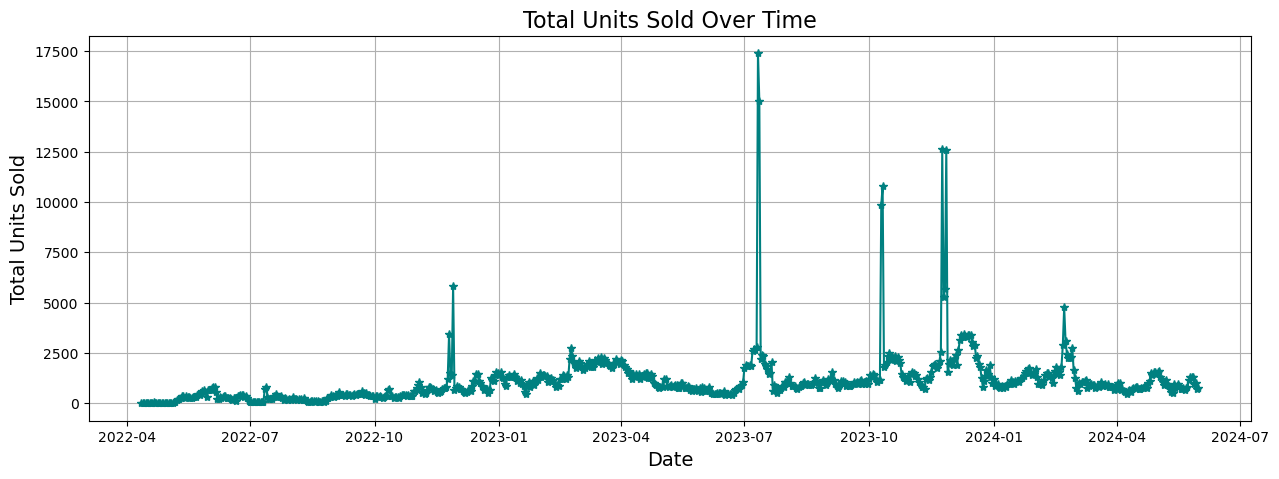

In [32]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

plt.figure(figsize=(15,5))
plt.plot(train_df.groupby('date')['units'].sum(), color='teal', linestyle='-', marker='*')
plt.title('Total Units Sold Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Units Sold', fontsize=14)
plt.grid(True)
plt.show()

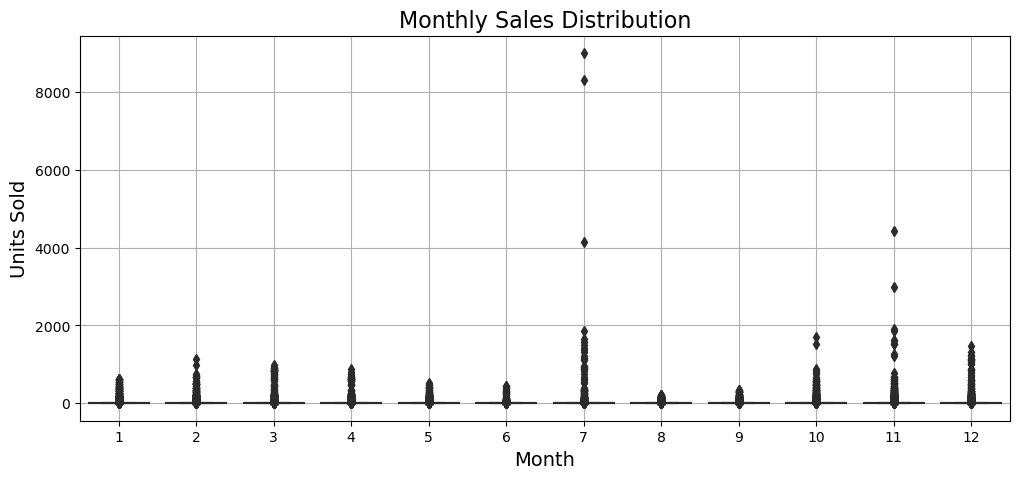

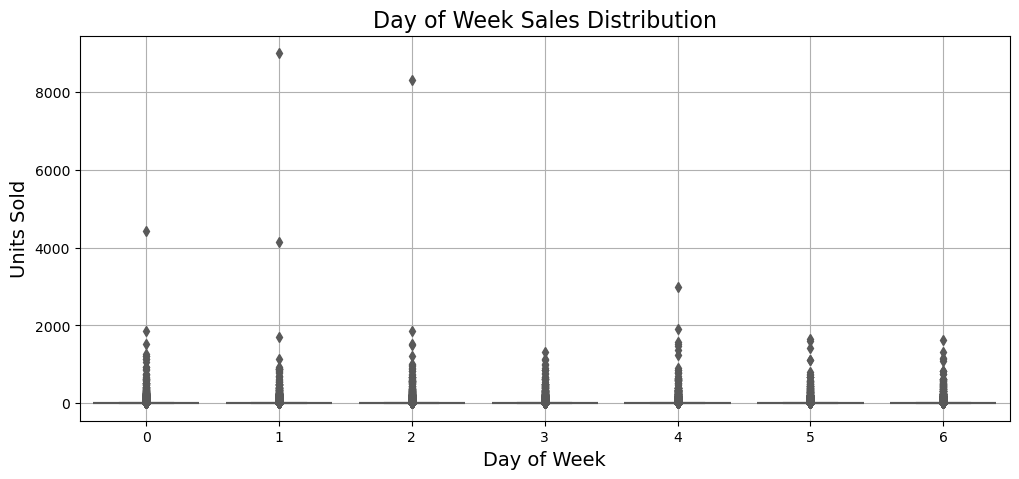

In [33]:
#seasonality
train_df['month'] = train_df['date'].dt.month
train_df['day_of_week'] = train_df['date'].dt.dayofweek

plt.figure(figsize=(12,5))
sns.boxplot(x='month', y='units', data=train_df, palette='Blues')
plt.title('Monthly Sales Distribution', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Units Sold', fontsize=14)
plt.grid(True)
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x='day_of_week', y='units', data=train_df, palette='coolwarm')
plt.title('Day of Week Sales Distribution', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Units Sold', fontsize=14)
plt.grid(True)
plt.show()

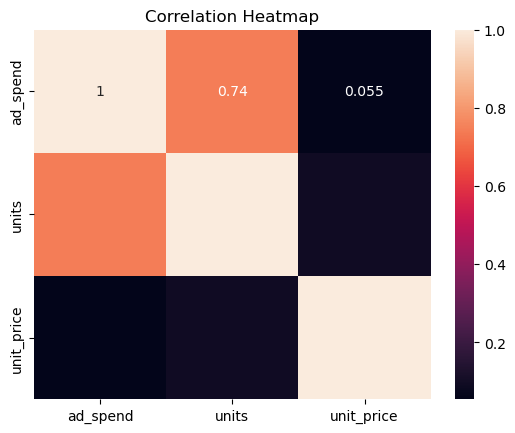

In [34]:
# correlation analysis
corr = train_df[['ad_spend', 'units', 'unit_price']].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [35]:
#item analysis
#top selling items
top_items = train_df.groupby('Item Id')['units'].sum().nlargest(10)
print("Top 10 selling items:", top_items)

#items with highest ad spend
top_ad_spend = train_df.groupby('Item Id')['ad_spend'].sum().nlargest(10)
print("\nTop 10 items by ad spend:", top_ad_spend)

Top 10 selling items: Item Id
B09KT5HMNY    102149.0
B0BGDWGRQB     99586.0
B09MR3Y296     82697.0
B09MR4B13C     78548.0
B0BGDX2Z3L     33810.0
B09KTMKDKJ     31790.0
B0BRCYQNSW     26531.0
B09MR3XT5G     21815.0
B0B699PLXD     21622.0
B0BGDZLDX2     20691.0
Name: units, dtype: float64

Top 10 items by ad spend: Item Id
B09KT5HMNY    851785.25
B09MR4B13C    607033.59
B09MR3Y296    548484.97
B0BRCYQNSW    434229.75
B09KTF8ZDQ    336946.80
B09KTMKDKJ    266972.17
B0BGDWGRQB    262212.18
B09KDZQJ6P    255192.82
B0B69B8R3C    247132.75
B09MR3XT5G    227750.13
Name: ad_spend, dtype: float64


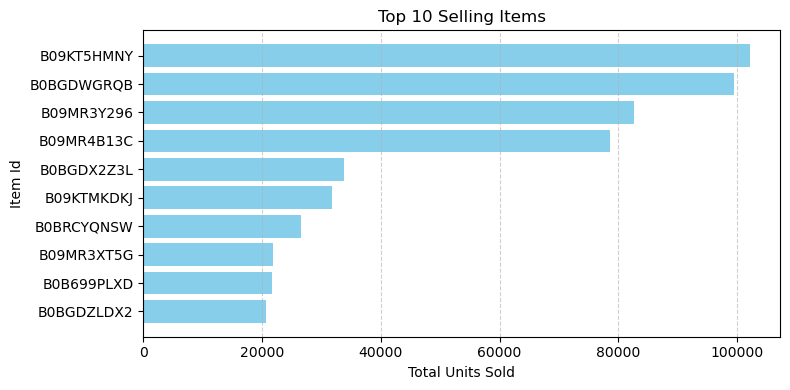

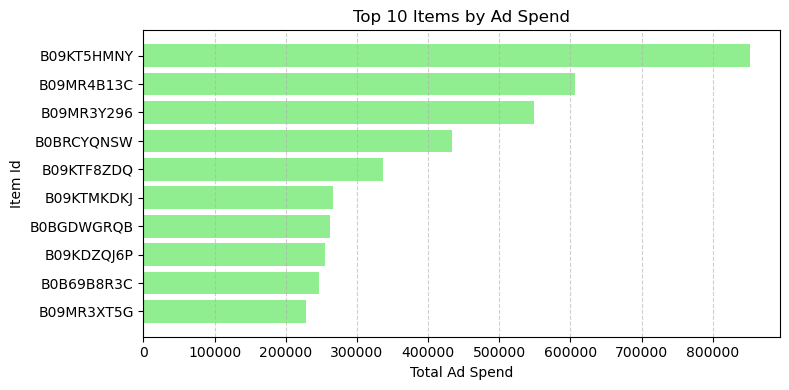

In [36]:
#horizontal bar graph for top selling items
plt.figure(figsize=(8, 4))
plt.barh(top_items.index, top_items.values, color='skyblue')
plt.xlabel('Total Units Sold')
plt.ylabel('Item Id')
plt.title('Top 10 Selling Items')
plt.gca().invert_yaxis()  # Invert y-axis to display top item at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#horizontal bar graph for items with highest ad spend
plt.figure(figsize=(8, 4))
plt.barh(top_ad_spend.index, top_ad_spend.values, color='lightgreen')
plt.xlabel('Total Ad Spend')
plt.ylabel('Item Id')
plt.title('Top 10 Items by Ad Spend')
plt.gca().invert_yaxis()  # Invert y-axis to display top item at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

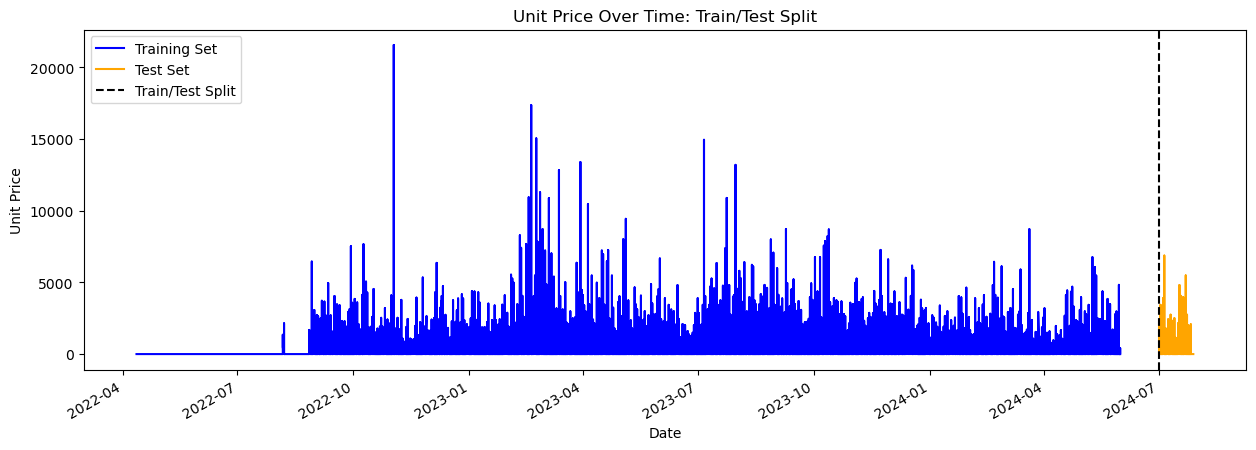

In [37]:
#unitprice over time (train and test split)

train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(x='date', y='unit_price', ax=ax, label='Training Set', color='blue')
test_df.plot(x='date', y='unit_price', ax=ax, label='Test Set', color='orange')
ax.axvline(pd.Timestamp('2024-07-01'), color='black', linestyle='--')
ax.set_title('Unit Price Over Time: Train/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Unit Price')
ax.legend(['Training Set', 'Test Set','Train/Test Split'])

plt.show()

# STEP 5: FEATURE CREATION

In [38]:
print(train_df.columns)

Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id', 'units',
       'unit_price', 'missing_name', 'month', 'day_of_week'],
      dtype='object')


In [39]:
print(test_df.columns)

Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id',
       'unit_price', 'missing_name'],
      dtype='object')


In [40]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [74]:
def create_features(df):
    if 'date' not in df.columns:
        raise ValueError("DataFrame must contain a 'date' column")
    
    df['date'] = pd.to_datetime(df['date'])
    
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df

train_df = create_features(train_df)

In [75]:
train_df = create_features(train_df)
test_df = create_features(test_df)

In [43]:
features = ['day_of_week', 'month', 'quarter', 'year', 'is_weekend']

In [44]:
print(train_df.columns)

Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id', 'units',
       'unit_price', 'missing_name', 'month', 'day_of_week', 'quarter', 'year',
       'is_weekend'],
      dtype='object')


In [45]:
print(test_df.columns)

Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id',
       'unit_price', 'missing_name', 'day_of_week', 'month', 'quarter', 'year',
       'is_weekend'],
      dtype='object')


In [47]:
print("Shape of dataset after feature engineering:", train_df.shape)
print("\nNew features added:")
print(train_df[['month', 'day_of_week', 'quarter', 'year',
       'is_weekend']].head())

Shape of dataset after feature engineering: (101488, 14)

New features added:
       month  day_of_week  quarter  year  is_weekend
62967      9            0        3  2023           0
65359     10            1        4  2023           0
69206     11            3        4  2023           0
767        5            3        2  2022           0
812        5            4        2  2022           0


In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101488 entries, 62967 to 101466
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   ID            101488 non-null  object        
 1   date          101488 non-null  datetime64[ns]
 2   Item Id       101488 non-null  object        
 3   Item Name     101488 non-null  object        
 4   ad_spend      101488 non-null  float64       
 5   anarix_id     101488 non-null  object        
 6   units         101488 non-null  float64       
 7   unit_price    101488 non-null  float64       
 8   missing_name  101488 non-null  int64         
 9   month         101488 non-null  int32         
 10  day_of_week   101488 non-null  int32         
 11  quarter       101488 non-null  int32         
 12  year          101488 non-null  int32         
 13  is_weekend    101488 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int32(4), int64(2), object(4)
memor

In [49]:
train_df.describe()

,date,ad_spend,units,unit_price,missing_name,month,day_of_week,quarter,year,is_weekend
count,101488,101488.000000,101488.000000,101488.000000,101488.000000,101488.000000,101488.000000,101488.000000,101488.000000,101488.000000
mean,2023-07-09 19:09:44.297651200,84.374182,8.511105,107.256203,0.018032,6.051405,2.996876,2.352682,2023.060175,0.284625
min,2022-04-12 00:00:00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2022.000000,0.000000
25%,2023-02-26 00:00:00,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,2023.000000,0.000000
50%,2023-07-16 00:00:00,0.720000,0.000000,0.000000,0.000000,6.000000,3.000000,2.000000,2023.000000,0.000000
75%,2023-12-13 00:00:00,21.642500,3.000000,0.000000,0.000000,9.000000,5.000000,3.000000,2023.000000,1.000000
max,2024-05-31 00:00:00,47934.990000,9004.000000,21557.390000,1.000000,12.000000,6.000000,4.000000,2024.000000,1.000000
std,NaN,464.354660,62.680788,424.513596,0.133067,3.488462,1.999103,1.134606,0.612774,0.451238


In [50]:
train_df.isnull().sum()

ID              0
date            0
Item Id         0
Item Name       0
ad_spend        0
anarix_id       0
units           0
unit_price      0
missing_name    0
month           0
day_of_week     0
quarter         0
year            0
is_weekend      0
dtype: int64

In [51]:
test_df.isnull().sum()

ID              0
date            0
Item Id         0
Item Name       0
ad_spend        0
anarix_id       0
unit_price      0
missing_name    0
day_of_week     0
month           0
quarter         0
year            0
is_weekend      0
dtype: int64

In [53]:
print("Shape of dataset after feature engineering:", train_df.shape)
print("\nNew features added:")
print(train_df[['month', 'day_of_week', 'quarter', 'year',]].head())

Shape of dataset after feature engineering: (101488, 14)

New features added:
       month  day_of_week  quarter  year
62967      9            0        3  2023
65359     10            1        4  2023
69206     11            3        4  2023
767        5            3        2  2022
812        5            4        2  2022


In [54]:
print("Shape of dataset after feature engineering:", test_df.shape)
print("\nNew features added:")
print(test_df[['month', 'day_of_week', 'quarter', 'year',
       'is_weekend']].head())

Shape of dataset after feature engineering: (2833, 13)

New features added:
   month  day_of_week  quarter  year  is_weekend
0      7            0        3  2024           0
1      7            0        3  2024           0
2      7            0        3  2024           0
3      7            0        3  2024           0
4      7            0        3  2024           0


# STEP 6: MODEL SELECTION 

In [55]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

## b. XGBoost 

In [56]:
print(train_df.columns)

Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id', 'units',
       'unit_price', 'missing_name', 'month', 'day_of_week', 'quarter', 'year',
       'is_weekend'],
      dtype='object')


In [57]:
print(test_df.columns)

Index(['ID', 'date', 'Item Id', 'Item Name', 'ad_spend', 'anarix_id',
       'unit_price', 'missing_name', 'day_of_week', 'month', 'quarter', 'year',
       'is_weekend'],
      dtype='object')


In [58]:
# Separate features and target variable from training data
X_train = train_df[features]
y_train = train_df['units']

In [59]:
X_test = test_df[features]

In [66]:
model = xgb.XGBRegressor(
    subsample=0.7,
    n_estimators=1000,
    min_child_weight=3,
    max_depth=3,
    learning_rate=0.01
)

In [67]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [68]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],
    verbose=100
)

[0]	validation_0-rmse:62.67904
[100]	validation_0-rmse:62.61096
[200]	validation_0-rmse:62.58460
[300]	validation_0-rmse:62.57098
[400]	validation_0-rmse:62.56220
[500]	validation_0-rmse:62.55689
[600]	validation_0-rmse:62.55265
[700]	validation_0-rmse:62.54844
[800]	validation_0-rmse:62.54572
[900]	validation_0-rmse:62.54352
[999]	validation_0-rmse:62.54133


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
test_df['units_pred'] = model.predict(X_test)

In [63]:
submission = test_df[['ID']]
submission['Target'] = test_df['units_pred']

In [64]:
submission.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


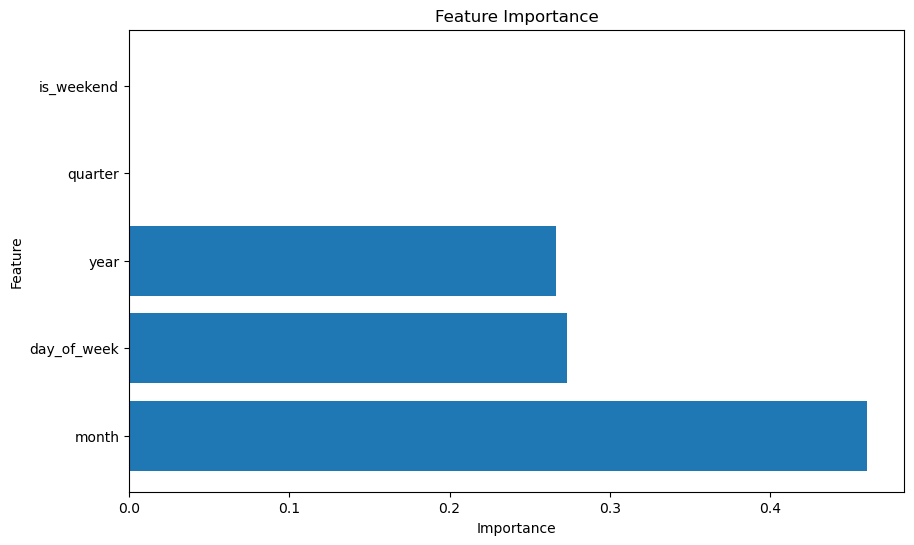

In [70]:
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error
train_predictions = model.predict(X_train)

mse = mean_squared_error(y_train, train_predictions)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3911.418409604966


# PERFORMING HYPER PARAMETER TUNING 

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [77]:
features = ['day_of_week', 'month', 'quarter', 'year', 'is_weekend']
target = 'units'

In [78]:
X_train = train_df[features]
y_train = train_df[target]

In [81]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [84]:
xgb = XGBRegressor()

In [85]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

In [86]:
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)
grid_search.fit(X_train_split, y_train_split)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'min_child_weight': [1, 3], 'n_estimators': [100, 200],
                         'subsample': [0.7, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [87]:
# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [88]:
# Evaluate on validation set
val_predictions = best_model.predict(X_val)
mse = mean_squared_error(y_val, val_predictions)
print(f"Best parameters: {best_params}")
print(f"Validation MSE: {mse}")

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Validation MSE: 1443.7185930621974


In [89]:
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [90]:
#test data predictions
X_test = test_df[features]
test_predictions = best_model.predict(X_test)

In [92]:
submission = pd.DataFrame({'ID': test_df['ID'], 'Target': test_predictions})
submission.to_csv('submission1.csv', index=False)